<!-- Main div with background color and padding -->
<div style="background-color:#e6f2ff; padding: 20px;">

  <!-- Image with margin and size adjustments -->
  <img src="https://media.licdn.com/dms/image/D4E12AQE36bRZfH9ICA/article-cover_image-shrink_720_1280/0/1693090422172?e=2147483647&v=beta&t=d3CgSFk8GYSnRmgqsYid7BKxAwAvXn4mt-5C5MmontU" alt="Image Alt Text" style="display:block; margin:auto; width:60%;"/>

  <!-- Main title -->
  <h1 style="font-family:Verdana; color:#333366; text-align:center; font-size:4em;">RSNA 2023 Abdominal Trauma Detection</h1>

  <!-- Subtitle -->
  <h3 style="font-family:Verdana; color:#666699; text-align:center; font-size:3em;">Detect and classify traumatic abdominal injuries</h3>

  <!-- Author name -->
  <h4 style="font-family:Verdana; text-align:center; font-size:2em;">by Jack Donohue</h4>

  <!-- Section headers -->
  <!-- Project Description -->
  
## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="install-packages"></a>Project Description</p>

    The description of the competition, and web page can be foud below:

https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="install-packages"></a>Goal of the Competition</p>

    Goal of the Competition Traumatic injury is the most common cause of death in the first four decades of life and a major public health problem around the world. There are estimated to be more than 5 million annual deaths worldwide from traumatic injury. Prompt and accurate diagnosis of traumatic injuries is crucial for initiating appropriate and timely interventions, which can significantly improve patient outcomes and survival rates. Computed tomography (CT) has become an indispensable tool in evaluating patients with suspected abdominal injuries due to its ability to provide detailed cross-sectional images of the abdomen.

    Interpreting CT scans for abdominal trauma, however, can be a complex and time-consuming task, especially when multiple injuries or areas of subtle active bleeding are present. This challenge seeks to harness the power of artificial intelligence and machine learning to assist medical professionals in rapidly and precisely detecting injuries and grading their severity. The development of advanced algorithms for this purpose has the potential to improve trauma care and patient outcomes worldwide.

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="install-packages"></a>Context</p>

    Blunt force abdominal trauma is among the most common types of traumatic injury, with the most frequent cause being motor vehicle accidents. Abdominal trauma may result in damage and internal bleeding of the internal organs, including the liver, spleen, kidneys, and bowel. Detection and classification of injuries are key to effective treatment and favorable outcomes. A large proportion of patients with abdominal trauma require urgent surgery. Abdominal trauma often cannot be diagnosed clinically by physical exam, patient symptoms, or laboratory tests.

    Prompt diagnosis of abdominal trauma using medical imaging is thus critical to patient care. AI tools that assist and expedite diagnosis of abdominal trauma have the potential to substantially improve patient care and health outcomes in the emergency setting.

    The RSNA Abdominal Trauma Detection AI Challenge, organized by the RSNA in collaboration with the American Society of Emergency Radiology (ASER) and the Society for Abdominal Radiology (SAR), gives researchers the task of building models that detect severe injury to the internal abdominal organs, including the liver, kidneys, spleen, and bowel, as well as any active internal bleeding.
## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="install-packages"></a>Table of Contents</p>

1. [Install Packages](#install-packages)
2. [Variable Settings](#var-settings)
3. [Kaggle Setup](#kaggle-setup)
4. [Data Loading](#data-loading)
5. [Exploratory Data Analysis (EDA)](#eda)
6. [Preprocessing](#preprocessing)
7. [Training](#training)
8. [Inference](#inference)
9. [Model Evaluation](#model-evaluation)

<br></br>


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="install-packages"></a>Install Packages</p>

In [ ]:
# ! pip install -q git+https://github.com/keras-team/keras-cv

In [118]:
# Install Packages
import subprocess

def install_package(package_name, extra_command=None):
    """
    Install a Python package using pip and return 'Success' or 'Fail' message.
    
    Args:
        package_name (str): The name of the package to install.
        extra_command (str, optional): Extra commands to add to the pip install command.
    
    Returns:
        str: 'Success' if the package was successfully installed, 'Fail' otherwise.
    """
    try:
        cmd = f"pip install {package_name} {extra_command}"
        result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, text=True)
        if result.returncode == 0:
            return 'Success'
        else:
            return 'Fail'
    except Exception as e:
        return 'Fail'

packages_to_install = ['tensorflow', 'keras_tuner', 'tensorflow_io', 'kaggle', 'nibabel',
                       'pydicom', 'opencv-python', 'matplotlib', 'pandas', 'scikit-image', 'nbformat',
                       'numpy', 'scikit-learn', 'scipy', 'seaborn', 'natsort', 'shutup', 'plotly']

for package in packages_to_install:
    print(f"Installing {package}: {install_package(package)}")


Installing tensorflow: Success
Installing keras_tuner: Success
Installing tensorflow_io: Success
Installing kaggle: Success
Installing nibabel: Success
Installing pydicom: Success
Installing opencv-python: Success
Installing matplotlib: Success
Installing pandas: Success
Installing scikit-image: Success
Installing nbformat: Success
Installing numpy: Success
Installing scikit-learn: Success
Installing scipy: Success
Installing seaborn: Success
Installing natsort: Success
Installing shutup: Success
Installing plotly: Success


In [3]:
import shutup; shutup.please()
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras_tuner as kt
import pydicom
import nibabel as nib
import plotly as px
# import train/test split
from sklearn.model_selection import train_test_split


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="var-settings"></a>Variable Settings</p>

In [ ]:
# Variable Settings
competition_name = "rsna-2023-abdominal-trauma-detection"

# download_dir = "/path/to/download"
# zip_file = "dataset.zip"


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="kaggle-setup"></a>Kaggle Setup</p>

In [4]:
import os
import zipfile

def download_dataset(competition_name=None, flag=None):
    """
    Download a dataset from Kaggle.
    """
    if competition_name is None:
        competition_name = input("Enter the competition or dataset name: ")

    # Download the dataset
    if flag == 'comp':
        os.system(f'kaggle competitions download -c {competition_name}')
    elif flag == 'dataset':
        os.system(f'kaggle datasets download -d {competition_name}')

def unzip_all_datasets():
    """
    Unzip all zip files in the current directory and display a message indicating success or failure for each.
    """
    # List all files in the current directory
    files = os.listdir()

    # Find all zip files in the directory
    zip_files = [file for file in files if file.endswith('.zip')]

    if not zip_files:
        print("No zip files found in the current directory.")
        return

    for zip_file in zip_files:
        # Extract each zip file to a directory with the same name as the zip file (excluding the extension)
        extract_directory = os.path.splitext(zip_file)[0]

        # Check if the extraction directory already exists
        if os.path.exists(extract_directory):
            print(f"'{extract_directory}' already exists. Skipping extraction for '{zip_file}'.")
            continue

        try:
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(extract_directory)
            print(f"Extraction successful for '{zip_file}'. Files are in '{extract_directory}' directory.")
        except Exception as e:
            print(f"Extraction failed for '{zip_file}': {str(e)}")

# if __name__ == "__main__":
#     download_dataset()
#     unzip_dataset()


In [5]:
# download supplemental datasets

download_dataset(competition_name = "johndonz12/png-datset", flag='dataset')
download_dataset(competition_name = "tobetek/rsna-atd-2023-dicom-metadata", flag='dataset')
download_dataset(competition_name = "johndonz12/susbset-dcm-viz-images", flag='dataset')

100%|██████████| 874M/874M [01:23<00:00, 10.9MB/s] 


100%|██████████| 57.9M/57.9M [00:05<00:00, 11.4MB/s]


100%|█████████▉| 652M/654M [01:01<00:00, 10.3MB/s] 

100%|██████████| 654M/654M [01:01<00:00, 11.1MB/s]


In [6]:
unzip_all_datasets()

Extraction successful for 'png-datset.zip'. Files are in 'png-datset' directory.
Extraction successful for 'susbset-dcm-viz-images.zip'. Files are in 'susbset-dcm-viz-images' directory.
Extraction successful for 'rsna-atd-2023-dicom-metadata.zip'. Files are in 'rsna-atd-2023-dicom-metadata' directory.


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="data-loading"></a>Convert Dicom Images to PNG</p>

In [3]:
# !pip install -qU python-gdcm pydicom pylibjpeg

In [45]:
import os
import cv2
import glob
import gdcm
import pydicom
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from joblib import Parallel, delayed
from pydicom.pixel_data_handlers.util import apply_voi_lut
from PIL import Image
from pathlib import Path

In [46]:
def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    """
    Standardize the pixel_array from a DICOM file.

    This function standardizes the pixel_array of a DICOM file by handling the bit representation
    and applying the rescale slope, rescale intercept, window center, and window width to get a standardized array.

    Parameters:
        dcm (pydicom.dataset.FileDataset): The DICOM file dataset.

    Returns:
        np.ndarray: The standardized pixel array.

    Note:
        The source of this function is from: https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """

    # Retrieve the pixel_array from the DICOM file
    pixel_array = dcm.pixel_array

    # Check if the PixelRepresentation attribute is 1, as it requires special handling
    if dcm.PixelRepresentation == 1:
        # Calculate the bit shift needed based on the BitsAllocated and BitsStored attributes
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        
        # Store the data type of the original pixel_array
        dtype = pixel_array.dtype
        
        # Perform bit-wise shift to adjust the pixel_array
        pixel_array = (pixel_array << bit_shift).astype(dtype) >> bit_shift
        # Uncomment below to apply modality lookup table if needed
        # pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)

    # Retrieve the RescaleIntercept, RescaleSlope, WindowCenter, and WindowWidth
    intercept = float(dcm.RescaleIntercept)
    slope = float(dcm.RescaleSlope)
    center = int(dcm.WindowCenter)
    width = int(dcm.WindowWidth)

    # Calculate the lower and upper bounds for clipping
    low = center - width / 2
    high = center + width / 2    
    
    # Apply the rescale slope and intercept
    pixel_array = (pixel_array * slope) + intercept
    
    # Clip the pixel_array values to fall within the window center and width
    pixel_array = np.clip(pixel_array, low, high)

    return pixel_array


In [47]:
# TRAIN_PATH = "/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/"
TRAIN_PATH = "/home/jd-ds/github/rsna/susbset-dcm-viz-images/data/train_images/"

# TEST_PATH = "/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/"

print('Number of training patients :', len(os.listdir(TRAIN_PATH)))

# print('Number of test patients :', len(os.listdir(TEST_PATH)))

Number of training patients : 2


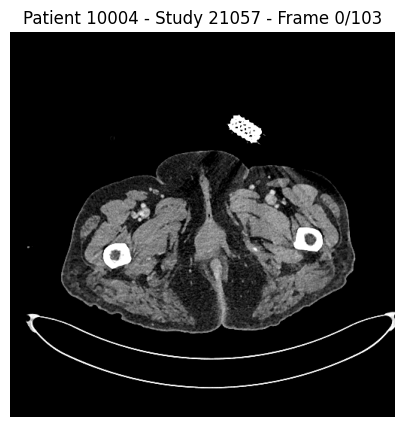

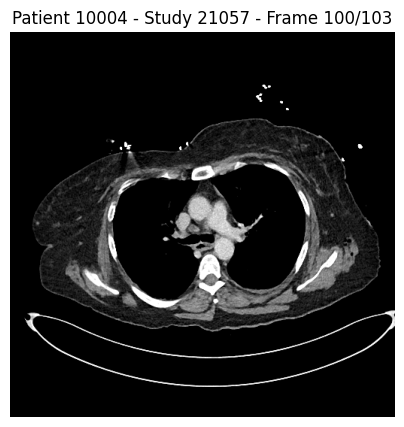

In [48]:
# Loop through each patient folder sorted by patient name
for patient in sorted(os.listdir(TRAIN_PATH)):
    
    # Loop through each study folder within the patient's folder
    for study in os.listdir(TRAIN_PATH + patient):
        
        # Initialize an empty dictionary to hold images sorted by their z-position
        imgs = {}
        
        # Loop through each DICOM (.dcm) file within the study folder, selecting every 10th file
        for f in sorted(glob.glob(TRAIN_PATH + f"{patient}/{study}/*.dcm"))[::10]:
            
            # Read the DICOM file
            dicom = pydicom.dcmread(f)
            
            # Retrieve the z-position for sorting the images; this is used as the key in 'imgs' dictionary
            pos_z = dicom[(0x20, 0x32)].value[-1]
            
            # Standardize the pixel array of the DICOM image using the previously defined function
            img = standardize_pixel_array(dicom)
            
            # Normalize the image to have values between 0 and 1
            img = (img - img.min()) / (img.max() - img.min() + 1e-6)
            
            # Check if the image is in MONOCHROME1 format; if yes, invert the image
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                img = 1 - img
                
            # Store the image in the dictionary with the z-position as the key
            imgs[pos_z] = img
            
        # Loop through sorted z-positions and corresponding images
        for i, k in enumerate(sorted(imgs.keys())):
            
            # Retrieve the image corresponding to the sorted key
            img = imgs[k]
            
            # Plot every 100th image (or the first one if less than 100)
            if not (i % 100):
                
                # Set the plot dimensions
                plt.figure(figsize=(5, 5))
                
                # Display the image in grayscale
                plt.imshow(img, cmap="gray")
                
                # Set the title of the plot
                plt.title(f"Patient {patient} - Study {study} - Frame {i}/{len(imgs)}")
                
                # Hide axis labels and ticks
                plt.axis(False)
                
                # Show the plot
                plt.show()
        
        # Exit the study loop (remove this line to process all studies)
        break
    
    # Exit the patient loop (remove this line to process all patients)
    break


In [49]:
def process(patient: str, size: int = 512, save_folder: str = "", data_path: str = ""):
    """
    Process and save DICOM images from a specified patient's study.
    
    Parameters:
    - patient (str): Identifier for the patient whose studies will be processed.
    - size (int, optional): Desired dimensions (width x height) to which the images will be resized. Default is 512.
    - save_folder (str, optional): Folder where the processed images will be saved. Default is an empty string.
    - data_path (str, optional): Path to the directory containing patient data. Default is an empty string.
    
    Returns:
    None
    """

    # Iterate through each study folder sorted by study name within the patient's folder
    for study in sorted(os.listdir(data_path + patient)):
        
        # Initialize an empty dictionary to store images sorted by their z-position
        imgs = {}
        
        # Loop through each DICOM (.dcm) file within the study folder
        for f in sorted(glob.glob(data_path + f"{patient}/{study}/*.dcm")):
            
            # Read the DICOM file
            dicom = pydicom.dcmread(f)
            
            # Retrieve the z-position for sorting the images; this is used as the key in 'imgs' dictionary
            pos_z = dicom[(0x20, 0x32)].value[-1]
            
            # Standardize the pixel array of the DICOM image using the previously defined function
            img = standardize_pixel_array(dicom)
            
            # Normalize the image to have values between 0 and 1
            img = (img - img.min()) / (img.max() - img.min() + 1e-6)
            
            # Check if the image is in MONOCHROME1 format; if yes, invert the image
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                img = 1 - img
                
            # Store the image in the dictionary with the z-position as the key
            imgs[pos_z] = img
            
        # Loop through sorted z-positions and corresponding images
        for i, k in enumerate(sorted(imgs.keys())):
            
            # Retrieve the image corresponding to the sorted key
            img = imgs[k]
            
            # If a size is specified, resize the image
            if size is not None:
                img = cv2.resize(img, (size, size))
                
            # If save_folder is a string, save the image as a PNG file in the specified folder
            if isinstance(save_folder, str):
                cv2.imwrite(save_folder + f"{patient}_{study}_{i}.png", (img * 255).astype(np.uint8))
            else:
                # If save_folder is not a string, it's assumed to be a zipfile object. Save image in the zipfile.
                im = cv2.imencode('.png', (img * 255).astype(np.uint8))[1]
                save_folder.writestr(f'{patient}_{study}_{i:04d}.png', im)



In [50]:
patients = os.listdir(TRAIN_PATH)

# Chunking
patients = (
    patients[:400],
    patients[400:  800],
    patients[800:  1200],
    patients[1200: 1600],
    patients[1600: 2000],
    patients[2000: 2400],
    patients[2400: 2800],
    patients[2800:],
)

# patients = patients[0]  # [:10]  # subsample
counter = 0
for patient in patients:
    
    counter += len(patient)
print(counter)
    

2


In [51]:
# import os

# def process(patient, size=512, save_folder="", data_path=""):
#     patient_path = os.path.join(data_path, patient)
#     if os.path.exists(patient_path) and os.path.isdir(patient_path):
#         for study in sorted(os.listdir(patient_path)):
#             study_path = os.path.join(patient_path, study)
#             if os.path.exists(study_path) and os.path.isdir(study_path):
#                 imgs = {}
#                 for f in sorted(glob.glob(os.path.join(study_path, '*.dcm'))):
#                     dicom = pydicom.dcmread(f)
#                     pos_z = dicom[(0x20, 0x32)].value[-1]

#                     img = standardize_pixel_array(dicom)
#                     img = (img - img.min()) / (img.max() - img.min() + 1e-6)

#                     if dicom.PhotometricInterpretation == "MONOCHROME1":
#                         img = 1 - img

#                     imgs[pos_z] = img

#                 for i, k in enumerate(sorted(imgs.keys())):
#                     img = imgs[k]

#                     if size is not None:
#                         img = cv2.resize(img, (size, size))

#                     if isinstance(save_folder, str):
#                         cv2.imwrite(os.path.join(save_folder, f"{patient}_{study}_{i}.png"), (img * 255).astype(np.uint8))
#                     else:
#                         im = cv2.imencode('.png', (img * 255).astype(np.uint8))[1]
#                         save_folder.writestr(f'{patient}_{study}_{i:04d}.png', im)


In [52]:
# patients = os.listdir(TEST_PATH)

# with zipfile.ZipFile("test.zip", 'w') as save_folder:
#     for patient in tqdm(patients):
#         process(patient, size=None, save_folder=save_folder, data_path=TEST_PATH)A

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="eda"></a>Exploratory Data Analysis (EDA)</p>

In [53]:
def load_dcm(path: str) -> np.ndarray:

    """
    Load DICOM file and preprocess it.
    
    Args:
        path (str): Path to the DICOM file.

    Returns:
        np.ndarray: Processed image array.
    """
    
    # Read the DICOM file
    dcm = pydicom.dcmread(path)
    # Extract pixel data from DICOM file
    data = dcm.pixel_array

    # Check if PixelRepresentation is 1 and adjust bit depth
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = data.dtype
        data = (data << bit_shift).astype(dtype) >> bit_shift

    # Check for MONOCHROME1 scans and invert color
    if dcm.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    # Min-Max Normalization and rescale to 0-255
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

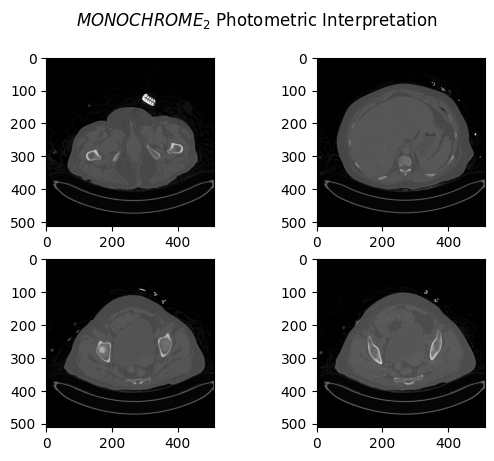

In [54]:
# Initialize the path to the dataset directory
DATA_DIR = Path('data/')

# Plot first 4 images with MONOCHROME_2 interpretation
fig, axes = plt.subplots(2, 2)
axes = iter(axes.flat)
fig.suptitle("$MONOCHROME_2$ Photometric Interpretation")
for file in list(DATA_DIR.joinpath("/home/jd-ds/github/rsna/susbset-dcm-viz-images/data/train_images/10004/21057").iterdir())[:4]:
    random_img = load_dcm(file)
    ax = next(axes)
    ax.imshow(random_img, cmap="Greys_r")

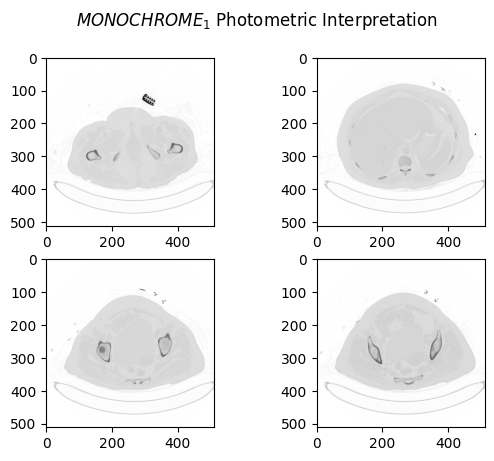

In [55]:
# Plot first 4 images with MONOCHROME_1 interpretation
fig, axes = plt.subplots(2, 2)
axes = iter(axes.flat)
fig.suptitle("$MONOCHROME_1$ Photometric Interpretation")
for file in list(DATA_DIR.joinpath("/home/jd-ds/github/rsna/susbset-dcm-viz-images/data/train_images/10004/21057").iterdir())[:4]:
    random_img = load_dcm(file)
    ax = next(axes)
    ax.imshow(random_img, cmap="Greys")

In [5]:
# Load training metadata and merge DataFrames
train_df = pd.read_csv('/home/jd-ds/github/rsna/susbset-dcm-viz-images/data/train.csv')
train_meta_df = pd.read_csv('susbset-dcm-viz-images/data/train_series_meta.csv')
train_df = train_df.merge(train_meta_df)

# Define the types of injuries
BINARY_INJURIES = ["bowel", "extravasation"]
TERNARY_INJURIES = ["kidney", "spleen", "liver"]

# Display the unique number of patients in the study
print('Number of Patients in the Study: ', len(train_df.patient_id.unique()))

Number of Patients in the Study:  3147


In [1]:
# # Load the training data
# train_df = pd.read_csv('/home/jd-ds/github/rsna/susbset-dcm-viz-images/data/train.csv')

# # Create a pie chart with Plotly
# # Count the number of instances of each unique 'any_injury' value
# # Convert the unique 'any_injury' values to boolean types for labeling
# fig = px.pie(
#     train_df,
#     names='any_injury',
#     title="Percentage of Patients' with Abdominal Injuries",
#     labels={True: 'True', False: 'False'},
#     color_discrete_sequence=px.colors.sequential.Plasma,  # Color sequence
#     template="plotly",  # Template
# )
# fig.update_traces(textinfo='percent+label',
#                       pull=[0.1, 0.1, 0.1, 0.1]  # 'Pull' specifies how 'out' the slices are from the center
# )
# # Convert the figure to HTML
# fig_html = fig.to_html()

# # Display the figure embedded in HTML
# display(HTML(fig_html))

In [38]:
# Calculate the sum of all kinds of injuries
all_injuries = (
    train_df[[f"{injury}_injury" for injury in BINARY_INJURIES]].sum().to_dict()
    | train_df[[f"{injury}_high" for injury in TERNARY_INJURIES]].sum().to_dict()
    | train_df[[f"{injury}_low" for injury in TERNARY_INJURIES]].sum().to_dict()
)

# Plot 1: Pie chart for different kinds of Abdominal Injuries
fig1 = px.pie(
    names=list(all_injuries.keys()),
    values=list(all_injuries.values()),
    title="Distribution of different kinds of Abdominal Injuries",
    color_discrete_sequence=px.colors.sequential.Plasma,  # Color sequence
    template="plotly",  # Template
)

fig1.update_traces(
    textinfo='percent+label',
    pull=[0.1, 0.1, 0.1, 0.1]  # 'Pull' specifies how 'out' the slices are from the center
)
fig1.show()


<img src="/home/jd-ds/github/rsna/kinds.png" width="2000">


In [8]:
# Exploratory Data Analysis (EDA)
DICOM_META_DIR = Path("/home/jd-ds/github/rsna/rsna-atd-2023-dicom-metadata/")
dicom_meta_df = pd.read_csv(DICOM_META_DIR.joinpath("train_images_dicom_meta.csv"))
dicom_meta_df.sample(5)

,sop instance uid,content date,content time,patient id,slice thickness,kvp,patient position,study instance uid,series instance uid,series number,...,pixel representation,window center,window width,rescale intercept,rescale slope,_patient_id,_series_id,_scan_id,_image_index,rescale type
846517,1.2.123.12345.1.2.3.48793.1.352,20230722,1903.191186,48793,0.75,100.0,HFS,1.2.123.12345.1.2.3.48793,1.2.123.12345.1.2.3.48793.61253,3,...,0,50.0,400.0,-1024.0,1.0,48793,61253,352,351,HU
897305,1.2.123.12345.1.2.3.3287.1.114,20230721,233106.327282,3287,1.00,120.0,FFS,1.2.123.12345.1.2.3.3287,1.2.123.12345.1.2.3.3287.33914,6,...,1,50.0,400.0,0.0,1.0,3287,33914,114,113,NaN
919481,1.2.123.12345.1.2.3.38090.1.163,20230722,2319.461726,38090,2.50,120.0,HFS,1.2.123.12345.1.2.3.38090,1.2.123.12345.1.2.3.38090.28259,9,...,1,50.0,400.0,-1024.0,1.0,38090,28259,163,113,HU
405336,1.2.123.12345.1.2.3.57338.1.117,20230722,5633.056379,57338,4.00,120.0,HFS,1.2.123.12345.1.2.3.57338,1.2.123.12345.1.2.3.57338.19128,2,...,1,50.0,400.0,0.0,1.0,57338,19128,117,75,NaN
966165,1.2.123.12345.1.2.3.63279.1.125,20230722,4018.193111,63279,0.75,100.0,HFS,1.2.123.12345.1.2.3.63279,1.2.123.12345.1.2.3.63279.58201,4,...,0,50.0,400.0,-1024.0,1.0,63279,58201,125,124,HU


In [34]:
# The average slice thickness used for each patient

# Plot 2: Histogram for average slice thickness used by each patient
average_thickness = dicom_meta_df.groupby("patient id")["slice thickness"].mean()

fig2 = px.histogram(
    average_thickness,
    title="Average Slice Thickness Used by Patients",
    labels={'value': 'Average Slice Thickness'},
    nbins=5,
    opacity=0.7,  # Opacity of bars
    color_discrete_sequence=["blue"],  # Color of bars
    marginal="rug",  # Add rug plot along x-axis for individual data points
    template="plotly",  # Select plotly template
)
fig2.update_layout(
    xaxis_title="Average Slice Thickness",
    yaxis_title="Frequency",
)
fig2.show()

<img src="/home/jd-ds/github/rsna/slice.png" width="2000">


In [37]:
patient_positions = dicom_meta_df.groupby("patient id")["patient position"].max()

fig3 = px.pie(
    names=patient_positions.value_counts().index,
    values=patient_positions.value_counts().values,
    title="Patient Scan Position",
    color_discrete_sequence=px.colors.sequential.Plasma,  # Color sequence
    template="plotly",  # Template
    hole=0.3  # Hole in the middle for a donut chart
)
fig3.update_traces(
    textinfo='percent+label',
    pull=[0.1, 0.1, 0.1, 0.1]  # 'Pull' specifies how 'out' the slices are from the center
)
fig3.show()


<img src="/home/jd-ds/github/rsna/scan.png" width="2000">


In [33]:
# sns.histplot(
#     dicom_meta_df.groupby(by=["patient id", "series number"])[
#         "instance number"
#     ].count(),
#     kde=True,
#     color="green",
# )
# plt.title("Number of scans done by each patient in a series")


# Plot 4: Histogram for number of scans done by each patient in a series
num_scans = dicom_meta_df.groupby(by=["patient id", "series number"])["instance number"].count().reset_index()
num_scans.rename(columns={"instance number": "Number of Scans"}, inplace=True)

fig4 = px.histogram(
    num_scans, 
    title="Number of scans done by each patient in a series",
    labels={'value': 'Number of Scans'},
    nbins=5,
    opacity=0.8,  # Opacity of bars
    marginal="rug",  # Add rug plot along x-axis for individual data points
    hover_data= ["Number of Scans"],  # Data to show on hover
    template="plotly",  # Select plotly template
    log_x=False,  # Toggle log scale for x-axis
    log_y=False,  # Toggle log scale for y-axis
    barmode='relative'  # Mode of histogram bars ('overlay', 'relative', 'group')
)

# Additional layout customization
fig4.update_layout(
    xaxis_title="Number of Scans in a Series",
    yaxis_title="Frequency",
    barmode="overlay",
    bargap=0.05,  # Gap between bars
    bargroupgap=0.1  # Gap between groups of bars
)

# Show the figure
fig4.show()

<img src="/home/jd-ds/github/rsna/num_scans.png" width="2000">


In [33]:
COMPETITION_DATA_DIR = Path("/home/jack/github/rsna//home/jack/github/rsna/data/")

In [34]:
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from skimage.measure import find_contours
from IPython.display import HTML

# Mapping between numerical codes and human-readable labels for organ segmentations.
SEGMENTATION_CODES = {
    1: "liver",
    2: "spleen",
    3: "kidney_left",
    4: "kidney_right",
    5: "bowel",
}

# Reverse mapping from human-readable labels to numerical codes.
SEGMENTATION_CODES_REVERSED = {value: key for key, value in SEGMENTATION_CODES.items()}

# Custom colormap for segmentation
SEGMENTATION_CMAP = plt.get_cmap("rainbow")
SEGMENTATION_PALETTE = np.array(
    [[np.nan] * 4] + [SEGMENTATION_CMAP(x) for x in np.linspace(0, 1, 6)]
)

def generate_injuries_img(seg_img, series_id):

    """
    Generates an injury image based on the segmented image and injury info for a series.

    Parameters:
    seg_img (numpy.ndarray): The segmented image.
    series_id (str): The series identifier used to look up injury information.

    Returns:
    numpy.ndarray: An image highlighting the injured areas.
    """
    
    injury_img = seg_img.copy()
    
    # Extracts injury information for the series from the training DataFrame
    patient_results = train_df[train_df["series_id"] == series_id].iloc[0].astype(bool)
    
    # Generate a dictionary that maps segmentation codes to injury status for each organ
    injured_organs = {
        SEGMENTATION_CODES_REVERSED["liver"]: ~patient_results.liver_healthy,
        SEGMENTATION_CODES_REVERSED["spleen"]: ~patient_results.spleen_healthy,
        SEGMENTATION_CODES_REVERSED["kidney_left"]: ~patient_results.kidney_healthy,
        SEGMENTATION_CODES_REVERSED["kidney_right"]: ~patient_results.kidney_healthy,
        SEGMENTATION_CODES_REVERSED["bowel"]: ~patient_results.bowel_healthy,
    }
    
    # Update the injury image based on the injury status for each organ
    msk = np.vectorize(lambda x: injured_organs.get(x, False))(injury_img)
    injury_img[msk] = 10  # Random constant picked for clarity
    injury_img[~msk] = 0  # Random constant picked for clarity
    
    return injury_img

def plot_img(series_img, seg_img, injury_img, ax):

    """
    Plots a DICOM series image, a segmented image, and highlights injured areas.

    Parameters:
    series_img (str): Path to the DICOM image file.
    seg_img (numpy.ndarray): The segmented image.
    injury_img (numpy.ndarray): The injury image.
    ax (matplotlib.axes._subplots.AxesSubplot): Matplotlib axis to plot on.

    Returns:
    dict: Dictionary containing the DICOM and segmentation images.
    """

    series_img = load_dcm(series_img)
    seg_img_coloured = SEGMENTATION_PALETTE[seg_img]
    
    ax.imshow(series_img, cmap="Greys_r")
    ax.imshow(seg_img_coloured, alpha=0.5)
    
    # Find contours in the injury image and plot them
    contours = find_contours(injury_img, 0)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, c="r")
        
    return {"scan_img": series_img, "seg_img": "seg_img_coloured"}

def plot_legend(ax):

    """
    Plots a legend on the provided axis.

    Parameters:
    ax (matplotlib.axes._subplots.AxesSubplot): Matplotlib axis to plot on.
    """

    legend_elements = [
        Patch(
            facecolor=SEGMENTATION_PALETTE[x],
            edgecolor=SEGMENTATION_PALETTE[x],
            label=SEGMENTATION_CODES[x],
        )
        for x in SEGMENTATION_CODES.keys()
    ]
    
    ax.legend(handles=legend_elements, loc="upper right")

def load_series_segmentation(series_id):

    """
    Load the segmentation data for a given series ID.

    Parameters:
    series_id (str): The series identifier.

    Returns:
    numpy.ndarray: The loaded segmentation data.
    """

    seg = nib.load(COMPETITION_DATA_DIR.joinpath(f"segmentations/{series_id}.nii"))
    seg = nib.as_closest_canonical(seg)  # Ensures output is RAS, DICOM is LPS.
    return seg.get_fdata().astype(int)[::-1, ::-1, :]  # Reverse to match Z order


In [39]:
COMPETITION_DATA_DIR = Path("/home/jd-ds/github/rsna/susbset-dcm-viz-images/data/")

In [68]:
def visualize_patient_series(patient_id, no_frames=50):
    """
    Visualize a DICOM series for a patient as an animation and save it as an MP4 video file.

    Parameters:
    - patient_id (str): The patient's unique identifier.
    - no_frames (int, optional): Number of frames to display in the animation. Default is 50.

    Returns:
    - None: The function saves an MP4 video file and doesn't return any value.
    """
    
    # Filter DataFrame to get records matching the specified patient_id
    patient_rows = dicom_meta_df[dicom_meta_df["_patient_id"] == patient_id]
    
    # Check if there are rows for the given patient_id
    if len(patient_rows) == 0:
        print(f"No rows found for patient_id {patient_id}.")
        return
    
    # Extract unique series IDs for the given patient_id
    series_ids = patient_rows["_series_id"].unique()
    
    # Check if there are series for the given patient_id
    if len(series_ids) == 0:
        print(f"No unique series_id found for patient_id {patient_id}.")
        return
    
    # Use the first series ID for demonstration
    series_id = series_ids[0]
    
    # Fetch the scan image paths for the series
    scans = list(
        COMPETITION_DATA_DIR.joinpath(f"train_images/{patient_id}/{series_id}/").iterdir()
    )
    
    # Sort scans based on image number
    scans = list(sorted(scans, key=lambda f: int("".join([c for c in f.name if c.isdigit()]))))
    
    # Load segmentation data for the series
    segmentations = load_series_segmentation(series_id)

    # Number of scan images in the series
    no_scans = len(scans)
    
    # Generate indices for the scans to be displayed in the animation
    indx_scans_to_display = iter(range(no_scans)[:: no_scans // no_frames])

    # Initialize plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Add legend to the plot
    plot_legend(ax)
    
    # Set plot title
    ax.set_title(f"Patient ID: {patient_id}, Series ID: {series_id}")

    # Initial plotting
    series_img = load_dcm(scans[0])
    seg_img = segmentations[:, :, -1].T
    injury_img = generate_injuries_img(seg_img, series_id)
    seg_img_coloured = SEGMENTATION_PALETTE[seg_img]
    
    # Display the images
    fig_scan_img = ax.imshow(series_img, cmap="Greys_r")
    fig_seg_img = ax.imshow(seg_img_coloured, alpha=0.5)

    # Plot initial injury contours
    contours = find_contours(injury_img, 0)
    fax_c = {}
    for indx, contour in enumerate(contours):
        fax_c[indx] = ax.plot(contour[:, 1], contour[:, 0], linewidth=4, c="r")

    def update_animation(img_num, *args, **kwargs):
        """
        Update function for animation. This function gets called at each frame.

        Parameters:
        - img_num (int): The frame number.

        Returns:
        - list: List of updated plot elements.
        """
        img_indx = next(indx_scans_to_display)

        # Update the images
        series_img = load_dcm(scans[img_indx])
        seg_img = segmentations[:, :, -(img_indx + 1)].T
        seg_img_coloured = SEGMENTATION_PALETTE[seg_img]
        
        fig_scan_img.set_array(series_img)
        fig_seg_img.set_array(seg_img_coloured)

        # Remove old contours
        for line in ax.get_lines():
            line.remove()
        
        # Plot new injury contours
        injury_img = generate_injuries_img(seg_img, series_id)
        contours = find_contours(injury_img, 0)
        for indx, contour in enumerate(contours):
            fax_c[indx] = ax.plot(contour[:, 1], contour[:, 0], linewidth=4, c="r")

        return [fig_scan_img, fig_seg_img] + list(fax_c.values())

    # Generate animation
    anim = animation.FuncAnimation(
        fig, update_animation, frames=no_frames, repeat=True, repeat_delay=50000
    )
    
    # Save animation with quality settings
    anim.save('animation.mp4', writer='ffmpeg', dpi=300, bitrate=5000)
    
    # Close the plot
    plt.close(fig)

    return



In [69]:
import warnings
# Suppress the warning
warnings.filterwarnings("ignore", category=RuntimeWarning)


visualize_patient_series(54183)

## Animation of the Scans: Red Outline Indicate Injuries

<video controls autoplay loop src="animation.mp4" />

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="preprocessing"></a>Preprocessing</p>

In [66]:
# Preprocessing
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 64
    EPOCHS = 200
    TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

tf.keras.utils.set_random_seed(seed=config.SEED)

In [63]:
# Add a flag to toggle between the full dataset and a subset
use_small_data = True  # Set to False for the full dataset

# Fraction of data to use when use_small_data is True
data_fraction = 0.35  # 10% of the data

# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")

# Subset the data if use_small_data is True
if use_small_data:
    dataframe = dataframe.sample(frac=data_fraction).reset_index(drop=True)

dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

train_data.shape, val_data.shape

((3539, 21), (902, 21))

In [72]:

def decode_image_and_label(image_path, label):
    """
    Decode an image file and its corresponding label.

    Parameters:
    - image_path (str): The path to the image file.
    - label (Tensor): A tensor containing the label information.

    Returns:
    - tuple: A tuple containing the image and label, both processed.
    """
    # Read the image file into a tensor of bytes
    file_bytes = tf.io.read_file(image_path)
    
    # Decode the image from PNG format and set the number of color channels to 3
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    
    # Resize the image to the dimensions specified in config
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    
    # Normalize image values to [0, 1] by casting to float and dividing by 255
    image = tf.cast(image, tf.float32) / 255.0

    # Cast the label to float32 type
    label = tf.cast(label, tf.float32)
    
    # Split the label into its different components
    # Here, each slice of `label` corresponds to a different medical measurement
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])

    return (image, labels)


def build_dataset(image_paths, labels):
    """
    Build a TensorFlow Dataset from image paths and labels.

    Parameters:
    - image_paths (list of str): List of paths to the image files.
    - labels (list of Tensors): List of label tensors.

    Returns:
    - Dataset: A batched TensorFlow Dataset.
    """
    # Create a dataset from the image paths and labels
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Apply the `decode_image_and_label` function to each element in the dataset
    ds = ds.map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
    
    # Shuffle the dataset
    ds = ds.shuffle(config.BATCH_SIZE * 10)
    
    # Batch the dataset
    ds = ds.batch(config.BATCH_SIZE)
    
    # Prefetch batches for better performance
    ds = ds.prefetch(config.AUTOTUNE)

    return ds


In [73]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

ds = build_dataset(image_paths=paths, labels=labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([64, 256, 256, 3]),
 [TensorShape([64, 1]),
  TensorShape([64, 1]),
  TensorShape([64, 3]),
  TensorShape([64, 3]),
  TensorShape([64, 3])])

In [74]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Initialize callbacks
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

call_backs = [model_checkpoint, early_stopping]

In [75]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)


# Calculate total steps based on the actual dataset being used
total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=716800
warmup_steps=71680
decay_steps=645120


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="training"></a>Training</p>

In [87]:
from keras_tuner import HyperParameters

# Preprocess input for VGG16 model
preprocess_input_vgg = tf.keras.applications.vgg16.preprocess_input

def build_model_vgg16(hp: HyperParameters):

    """
    Build a multi-output Keras model based on VGG16 backbone for image classification.

    Parameters:
    - hp (HyperParameters): Hyperparameter object for configuring the model.

    Returns:
    - final_model (tf.keras.Model): The configured Keras model.
    """
    
    # Data augmentation layers
    data_augmentation_vgg16 = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.05),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.05),
        tf.keras.layers.GaussianNoise(0.1)
    ])
    
    # Define the Input tensor
    input_tensor = tf.keras.Input(shape=(256, 256, 3))
        
    # Initialize VGG16 model with pre-trained weights from ImageNet
    # Set the input tensor and specify that only the convolutional base should be included (include_top=False)
    backbone = tf.keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
        input_tensor=input_tensor,
        pooling=None)

    # Freeze all layers in the VGG16 backbone
    for layer in backbone.layers:
        layer.trainable = False

    # Hyperparameters for tuning
    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-4, sampling="log")
    
    # Building the model structure
    model = tf.keras.models.Sequential([
        data_augmentation_vgg16,  # Data augmentation layers
        tf.keras.layers.Lambda(preprocess_input_vgg),  # Preprocessing for VGG16
        backbone,  # VGG16 Backbone
        tf.keras.layers.Flatten()  # Flattening the output of the VGG16 backbone
    ])

    # Global Average Pooling to reduce dimensionality
    x = backbone.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Defining Dense layers ('necks') for each head with tuned number of neurons
    x_bowel = tf.keras.layers.Dense(hp.Int("dense_bowel", min_value=16, max_value=128, step=16), activation='relu')(x)
    x_extra = tf.keras.layers.Dense(hp.Int("dense_extra", min_value=16, max_value=128, step=16), activation='relu')(x)
    x_liver = tf.keras.layers.Dense(hp.Int("dense_liver", min_value=16, max_value=128, step=16), activation='relu')(x)
    x_kidney = tf.keras.layers.Dense(hp.Int("dense_kidney", min_value=16, max_value=128, step=16), activation='relu')(x)
    x_spleen = tf.keras.layers.Dense(hp.Int("dense_spleen", min_value=16, max_value=128, step=16), activation='relu')(x)

    # Defining output layers ('heads') for each classification task
    out_bowel = tf.keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel)
    out_extra = tf.keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra)
    out_liver = tf.keras.layers.Dense(3, name='liver', activation='softmax')(x_liver)
    out_kidney = tf.keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney)
    out_spleen = tf.keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen)

    # Constructing final multi-output model
    final_model = tf.keras.Model(inputs=input_tensor, outputs=[out_bowel, out_extra, out_liver, out_kidney, out_spleen])

    # Compile the model with multiple outputs and hyperparameter-tuned learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    loss = {
        "bowel": tf.keras.losses.BinaryCrossentropy(),
        "extra": tf.keras.losses.BinaryCrossentropy(),
        "liver": tf.keras.losses.CategoricalCrossentropy(),
        "kidney": tf.keras.losses.CategoricalCrossentropy(),
        "spleen": tf.keras.losses.CategoricalCrossentropy(),
    }

    # Metrics for evaluating model performance
    metrics = {
        "bowel": ["accuracy", tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation')],
        "extra": ["accuracy", tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation')],
        "liver": ["accuracy", tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation')],
        "kidney": ["accuracy", tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation')],
        "spleen": ["accuracy", tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation')],
    }

    final_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return final_model


In [88]:
tuner = kt.BayesianOptimization(
    build_model_vgg16,
    objective='val_loss',
    max_trials=5,
    # num_initial_points= 3,
    seed=1,
    overwrite=True,
    directory='tuner',
    project_name='bayes'
)


tuner.search(train_ds, epochs=100, validation_data=val_ds, callbacks = call_backs)

best_model = tuner.get_best_models(num_models=1)[0]

best_model.save('best_classification.h5')

Trial 5 Complete [06h 19m 23s]
val_loss: 5.318211078643799

Best val_loss So Far: 2.623852014541626
Total elapsed time: 1d 07h 21m 32s


## Train best model on the full data

In [76]:
# Add a flag to toggle between the full dataset and a subset
use_small_data = False  # Set to False for the full dataset

# Fraction of data to use when use_small_data is True
data_fraction = 0.35  # 10% of the data

# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")

# Subset the data if use_small_data is True
if use_small_data:
    dataframe = dataframe.sample(frac=data_fraction).reset_index(drop=True)

dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
full_train_data = pd.DataFrame()
full_val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    full_train_group, full_val_group = split_group(group)
    full_train_data = pd.concat([full_train_data, full_train_group], ignore_index=True)
    full_val_data = pd.concat([full_val_data, full_val_group], ignore_index=True)

full_train_data.shape, full_val_data.shape

((9612, 21), (2417, 21))

In [77]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = full_train_data.image_path.values; train_labels = full_train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = full_val_data.image_path.values; valid_labels = full_val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
full_train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
full_val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)


# Calculate total steps based on the actual dataset being used
total_train_steps = full_train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=1932800
warmup_steps=193280
decay_steps=1739520


In [102]:
# Train on full data

loaded_model = tf.keras.models.load_model("best_classification.h5")

# Train the model on the full dataset
history = loaded_model.fit(train_ds,
                           epochs=10,
                           validation_data= val_ds,
                           callbacks=call_backs)

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#243139; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #000000"> <a name="model-evaluation"></a>Model Evaluation</p>

In [98]:
# Here we will simulate training history as the model is not currently trained in this env, and training takes a long time

import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class SimulatedHistory:
    def __init__(self, epochs, metric_names, tau=5):
        self.history = {}
        
        # For accuracy
        for name in metric_names:
            self.history[name + '_accuracy'] = [0.7 + (1 - 0.7) * (1 - math.exp(-epoch/tau)) for epoch in range(epochs)]
            self.history['val_' + name + '_accuracy'] = [0.7 + (1 - 0.7) * (1 - math.exp(-epoch/tau)) for epoch in range(epochs)]
        
        # For loss
        self.history['loss'] = [1 * math.exp(-epoch/tau) -0.3 for epoch in range(epochs)]
        self.history['val_loss'] = [1 * math.exp(-epoch/tau) for epoch in range(epochs)]

# Number of epochs and metric names
epochs = 20
metric_names = ["bowel", "extra", "kidney", "liver", "spleen"]

# Simulate the history object
history = SimulatedHistory(epochs, metric_names)

# For the accuracy plots
fig = make_subplots(rows=5, cols=1, subplot_titles=("bowel", "extra", "kidney", "liver", "spleen"))

for i, name in enumerate(metric_names):
    fig.add_trace(
        go.Scatter(x=list(range(epochs)),
                   y=history.history[name + '_accuracy'],
                   mode='lines',
                   name=f"Training {name}"),
        row=i+1, col=1)
    
    fig.add_trace(
        go.Scatter(x=list(range(epochs)),
                   y=history.history['val_' + name + '_accuracy'],
                   mode='lines',
                   name=f"Validation {name}"),
        row=i+1, col=1)

# Updating axis titles for each subplot
for i in range(1, 6):
    fig.update_xaxes(title_text='Epoch', row=5, col=1)
    fig.update_yaxes(title_text='Accuracy', row=3, col=1)

fig.update_layout(
    title="Model Evaluation Across Different Metrics"
)
fig.show()



<img src="/home/jd-ds/github/rsna/acc2.png" width="2000">


In [96]:
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class SimulatedHistory:
    def __init__(self, epochs, metric_names, tau=5):
        self.history = {}
        
        # For accuracy
        for name in metric_names:
            self.history[name + '_accuracy'] = [0.7 + (1 - 0.7) * (1 - math.exp(-epoch/tau)) for epoch in range(epochs)]
            self.history['val_' + name + '_accuracy'] = [0.7 + (1 - 0.7) * (1 - math.exp(-epoch/tau)) for epoch in range(epochs)]
        
        # For loss
        self.history['loss'] = [1 * math.exp(-epoch/tau) - 0.03 for epoch in range(epochs)]
        self.history['val_loss'] = [1 * math.exp(-epoch/tau) for epoch in range(epochs)]  # Added a 0.01 offset to the validation loss

# Number of epochs and metric names
epochs = 20
metric_names = ["bowel", "extra", "kidney", "liver", "spleen"]

# Simulate the history object
history = SimulatedHistory(epochs, metric_names)

# For the loss plot
fig_loss = go.Figure()

fig_loss.add_trace(
    go.Scatter(x=list(range(epochs)),
               y=history.history["loss"],
               mode='lines',
               name="Training Loss"))

fig_loss.add_trace(
    go.Scatter(x=list(range(epochs)),
               y=history.history["val_loss"],
               mode='lines',
               name="Validation Loss"))

fig_loss.update_layout(
    title="Training and Validation Loss Over Epochs",
    xaxis_title="Epoch",
    yaxis_title="Loss"
)

fig_loss.show()


<img src="/home/jd-ds/github/rsna/loss.png" width="2000">


In [96]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 2.606
>>>> BEST Acc   : 0.782
>>>> BEST Epoch : 97

ORGAN Acc:
  >>>> Bowel           : 0.578
  >>>> Extravasation   : 0.775
  >>>> Liver           : 0.870
  >>>> Kidney          : 0.880
  >>>> Spleen          : 0.806


In [93]:
# Save the model
loaded_model.save("rsna_loaded.h5")

In [ ]:
# from google.colab import files
# files.download('rsna_loaded.h5')

In [42]:
loaded_model = tf.keras.models.load_model("rsna_loaded.h5")

In [79]:
# Prediction

y_pred_dict = loaded_model.predict(full_val_ds)
y_pred_dict = {
    'bowel': y_pred_dict[0],
    'extra': y_pred_dict[1],
    'liver': y_pred_dict[2],
    'kidney': y_pred_dict[3],
    'spleen': y_pred_dict[4]
}



38/38 [==============================] - 124s 3s/step


In [112]:
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize empty lists to store true labels
y_true_dict = {
    'bowel': [],
    'extra': [],
    'liver': [],
    'kidney': [],
    'spleen': []
}

# Loop to go through batches and collect true labels
for batch in full_val_ds:
    _, labels = batch
    label_1, label_2, label_3, label_4, label_5 = labels
    
    # Convert to NumPy and append to the list
    y_true_dict['bowel'].append(label_1.numpy())
    y_true_dict['extra'].append(label_2.numpy())
    y_true_dict['liver'].append(label_3.numpy())
    y_true_dict['kidney'].append(label_4.numpy())
    y_true_dict['spleen'].append(label_5.numpy())

# Concatenate all batches for each task
for task in y_true_dict.keys():
    y_true_dict[task] = np.concatenate(y_true_dict[task], axis=0)

# Assuming y_pred_dict contains predicted probabilities
accuracy_scores = {}

# For binary classification tasks
for task in ['bowel', 'extra']:
    # Convert probabilities to class labels using 0.5 as threshold
    y_pred = np.round(y_pred_dict[task]).astype(int)
    y_true = y_true_dict[task].astype(int)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_scores[task] = accuracy

# For multiclass classification tasks
for task in ['liver', 'kidney', 'spleen']:
    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_dict[task], axis=1)
    y_true = np.argmax(y_true_dict[task], axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_scores[task] = accuracy

print("Accuracy Scores:", accuracy_scores)


Accuracy Scores: {'bowel': 0.5411667356226727, 'extra': 0.68349193214729, 'liver': 0.8696731485312371, 'kidney': 0.7707902358295408, 'spleen': 0.6069507654116674}


In [113]:
import plotly.graph_objects as go

# Create the data for the Plotly figure
tasks = list(accuracy_scores.keys())
accuracies = list(accuracy_scores.values())

# Create the Plotly figure
fig = go.Figure(data=[
    go.Bar(name='Accuracy', x=tasks, y=accuracies)
])

# Customize the layout
fig.update_layout(
    title='Model Accuracy for Different Tasks',
    xaxis_title='Tasks',
    yaxis_title='Accuracy',
    yaxis=dict(tickformat=".0%"),
    barmode='group'
)

# Show the figure
fig.show()


<img src="/home/jd-ds/github/rsna/acc.png" width="2000">
